
🕵️ RUNNING DIAGNOSTIC FOR: 🐮 Buy Sniper V1
📊 Test Data Size: 621 rows (Vaulted Data)


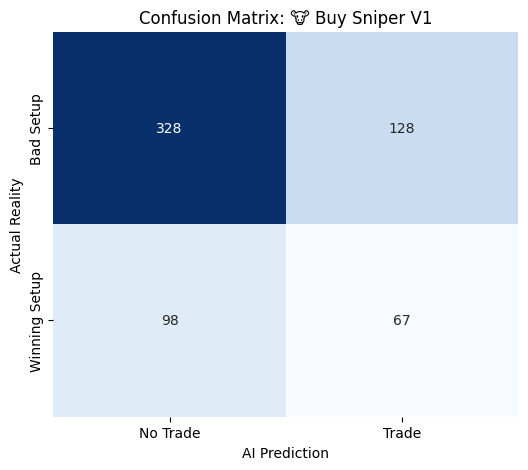


📈 PERFORMANCE METRICS (Default 0.50 Threshold)
   ► Trades Taken:      195 (out of 621 opportunities)
   ► AI Precision:      34.36% (Win Rate)
   ► Market Baseline:   26.57% (Random Guessing)
   ► Recall (Capture):  40.61%

💰 PROFITABILITY CHECK
   ► Winning Trades: 67
   ► Losing Trades:  128
   ► Net Result:     -27.50R
   ❌ STATUS: UNPROFITABLE

🎚️ SENSITIVITY ANALYSIS (Precision vs Volume)
   Threshold    Trades     Win Rate (Precision)
   ---------------------------------------------
   0.35         475        28.42%
   0.4          405        29.88%
   0.45         304        31.58%
   0.5          195        34.36%
   0.55         82         40.24%
   0.6          23         39.13%
   0.65         2          N/A (Too few trades)
   0.7          0          N/A (Too few trades)

🔍 Recommendation: Optimal Threshold appears to be 0.55 (Precision: 40.24%)


C:\Users\casus\AppData\Local\Temp\ipykernel_6336\787842145.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(FEATURES)[indices], palette='viridis')


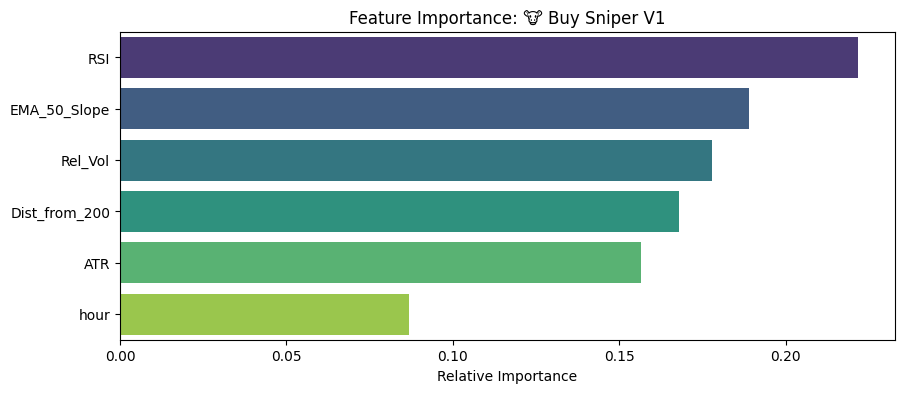

In [2]:
# 05_model_evaluation_diagnostics.ipynb

import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

# --- CONFIGURATION ---
DATA_DIR = "../data"
MODELS_DIR = "../models"

# Vault Files (The "Final Exam" Data - NEVER seen during training)
VAULT_BUY_TEST = os.path.join(DATA_DIR, "Vault_Test_Buy.parquet")
VAULT_SELL_TEST = os.path.join(DATA_DIR, "Vault_Test_Sell.parquet")

# Model Files (The Tuned Brains we just trained)
MODEL_BUY_PATH = os.path.join(MODELS_DIR, "RF_Buy_Production.joblib")
# MODEL_SELL_PATH = os.path.join(MODELS_DIR, "RF_Sell_Production.joblib")

# Features (MUST match training exactly)
FEATURES = [
    'EMA_50_Slope', 
    'Dist_from_200', 
    'RSI', 
    'ATR', 
    'Rel_Vol', 
    'hour'
]

# --- THE DIAGNOSTIC ENGINE ---
def run_full_diagnostic(model_path, data_path, target_col, model_name="Model"):
    print(f"\n{'='*60}")
    print(f"🕵️ RUNNING DIAGNOSTIC FOR: {model_name}")
    print(f"{'='*60}")

    # 1. Load Resources
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return
    
    if not os.path.exists(data_path):
        print(f"❌ Data file not found: {data_path}")
        return

    model = joblib.load(model_path)
    df_test = pd.read_parquet(data_path).dropna()
    
    X_test = df_test[FEATURES]
    y_true = df_test[target_col]
    
    print(f"📊 Test Data Size: {len(df_test)} rows (Vaulted Data)")
    
    # 2. Generate Predictions
    # Class predictions (0 or 1) - Default Threshold 0.5
    y_pred = model.predict(X_test)
    # Probability predictions (0.0 to 1.0) - For Sensitivity Analysis
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 3. Safety Check: Did it trade?
    total_trades = np.sum(y_pred)
    if total_trades == 0:
        print("⚠️ WARNING: Model is 'Dormant' (Predicted 0 trades at 0.5 threshold).")
        # Continue to Sensitivity Analysis anyway, maybe 0.4 threshold works?
    
    # 4. Confusion Matrix (The Truth Table)
    cm = confusion_matrix(y_true, y_pred)
    # Handle cases where model predicts only one class
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        # Fallback if model predicts only 0s or only 1s
        tn = cm[0,0] if 0 in y_true.values else 0
        tp = cm[0,0] if 1 in y_true.values and len(cm)==1 else 0
        fp, fn = 0, 0 # Approximate for edge case

    # Plot CM
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Trade', 'Trade'], yticklabels=['Bad Setup', 'Winning Setup'])
    plt.xlabel('AI Prediction')
    plt.ylabel('Actual Reality')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    # 5. The Sniper Metrics (Baseline vs AI)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    win_rate_baseline = y_true.mean()
    
    print("\n📈 PERFORMANCE METRICS (Default 0.50 Threshold)")
    print(f"   ► Trades Taken:      {total_trades} (out of {len(df_test)} opportunities)")
    print(f"   ► AI Precision:      {precision:.2%} (Win Rate)")
    print(f"   ► Market Baseline:   {win_rate_baseline:.2%} (Random Guessing)")
    print(f"   ► Recall (Capture):  {recall:.2%}")
    
    # 6. Profitability Simulator (R-Multiples)
    # Assumptions: Win = +1.5R, Loss = -1.0R
    wins = tp
    losses = fp
    net_r = (wins * 1.5) - (losses * 1.0)
    
    print(f"\n💰 PROFITABILITY CHECK")
    print(f"   ► Winning Trades: {wins}")
    print(f"   ► Losing Trades:  {losses}")
    print(f"   ► Net Result:     {net_r:.2f}R")
    
    if net_r > 0:
        print(f"   ✅ STATUS: PROFITABLE")
    else:
        print(f"   ❌ STATUS: UNPROFITABLE")

    # 7. SENSITIVITY ANALYSIS (Crucial for the Buy Model)
    # We test strictness: "What if we only take trades where Confidence > X?"
    print("\n🎚️ SENSITIVITY ANALYSIS (Precision vs Volume)")
    print(f"   {'Threshold':<12} {'Trades':<10} {'Win Rate (Precision)':<20}")
    print(f"   {'-'*45}")
    
    thresholds = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70]
    best_thresh = 0.5
    best_prec = 0
    
    for thresh in thresholds:
        custom_preds = (y_prob >= thresh).astype(int)
        count = np.sum(custom_preds)
        
        if count > 5: # Ignore if too few trades (statistically insignificant)
            prec = precision_score(y_true, custom_preds, zero_division=0)
            print(f"   {thresh:<12} {count:<10} {prec:.2%}")
            
            if prec > best_prec:
                best_prec = prec
                best_thresh = thresh
        else:
            print(f"   {thresh:<12} {count:<10} N/A (Too few trades)")

    print(f"\n🔍 Recommendation: Optimal Threshold appears to be {best_thresh} (Precision: {best_prec:.2%})")

    # 8. Feature Importance (Visual)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=importances[indices], y=np.array(FEATURES)[indices], palette='viridis')
    plt.title(f'Feature Importance: {model_name}')
    plt.xlabel('Relative Importance')
    plt.show()

# --- EXECUTE DIAGNOSTICS ---

# 1. Run Sell Model First (The Star)
# run_full_diagnostic(MODEL_SELL_PATH, VAULT_SELL_TEST, "LABEL_SELL", "🐻 Sell Sniper V1")

# 2. Run Buy Model Second (The Rescue Mission)
run_full_diagnostic(MODEL_BUY_PATH, VAULT_BUY_TEST, "LABEL_BUY", "🐮 Buy Sniper V1")